# Kernel PCA
We start with matrix $X$ of dimensions $(n, m)$, where $n$ is the dimensionality of vectors and $m$ a number of samples.
From original space we would like to transform $X$ to feature space, possibly $\infty$-dim:
$$\phi: R^n -> F \, .$$

To compute covariance matrix in feature space, we firstly make a normalization $\widetilde{\phi}(\mathbf{x}_i) = \phi(\mathbf{x}_i) - \frac{1}{m}\sum_{j=1}^{m} \phi(\mathbf{x}_j)$.
Now the covariance matrix of the feature space is $$ C = \frac{1}{m} \sum_{i=1}^{m} \widetilde{\phi}(\mathbf{x}_i) \widetilde{\phi}(\mathbf{x}_i)^T \, ,$$ and we wish to solve eigenvalue problem $$ \lambda U = C U \, .$$
As all vectors $\mathbf{u}_k$ lie in the span of $\widetilde{\phi}(\mathbf{x}_i), i \in [1, \ldots, m]$, for the eigenvalue problem we can write:
$$ \lambda_k \, \widetilde{\phi}(\mathbf{x}_i)^T \cdot \mathbf{u}_k = \widetilde{\phi}(\mathbf{x}_i)^T \cdot C\mathbf{u}_k \, ,$$
$$\mathbf{u}_k = \sum_{i=1}^{m} \alpha_i^k \, \widetilde{\phi}(\mathbf{x}_i) \, .$$

Combining everything together, we can write: $$ \lambda_k \mathbf{\alpha}^k = \frac{1}{m} \widetilde{K} \mathbf{\alpha}^k \, ,$$
where $\widetilde{K}_{ij} = \widetilde{\phi}(\mathbf{x}_i)^T \widetilde{\phi}(\mathbf{x}_j) $$ is (normalized) kernel. In this way, we can bypass definition of the feature space and use a kernel function instead.

## Algorithm
- compute $K$ from $X$
- solve $\lambda \mathbf{\alpha}^k = \frac{1}{m} \widetilde{K} \mathbf{\alpha}^k$
- normalize $\mathbf{\alpha}^k$ by $\mathbf{\alpha}^k \cdot \mathbf{\alpha}^k = 1 / (m \lambda_k)$
- extract PCA components by $a_\mathrm{PCA}^k(\mathbf{x}) = \mathbf{u}_k \cdot \widetilde{\phi}(\mathbf{x}) = \sum_{i=1}^m \alpha_i^k \widetilde{\phi}(\mathbf{x}_i)^T \widetilde{\phi}(\mathbf{x})$

In [1]:
import os
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/cluster/shared/software/libs/cuda/11a"
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".95"
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import jax
# jax.config.update("jax_platform_name", "cpu")
# jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import KernelPCA
import spax

# Kernel PCA in `sklearn`
Firstly we compute `rbf` kernel PCA with scikit-learn and after continue with functions implemented here.

In [2]:
kpca = KernelPCA(
    n_components = 3,
    kernel = "rbf",
    gamma = 0.1,
    fit_inverse_transform = True,
    alpha = 1.0,
    )

(4000, 2)

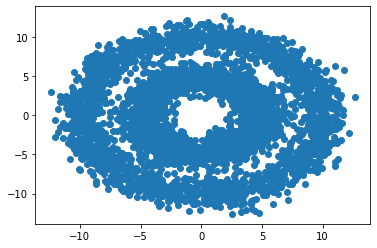

In [3]:
M = 4000
N = 2
rho1 = 5 + np.random.normal(scale = 1, size = M // 2)
rho2 = 10 + np.random.normal(scale = 1, size = M // 2)
rho = np.concatenate((rho1, rho2))
phi = np.random.uniform(0.0, 2 * np.pi, size = M)
x = rho * np.cos(phi)
y = rho * np.sin(phi)
data = np.stack((x, y), axis = -1)
plt.scatter(x, y)
data.shape

In [4]:
kpca.fit(data)

KernelPCA(fit_inverse_transform=True, gamma=0.1, kernel='rbf', n_components=3)

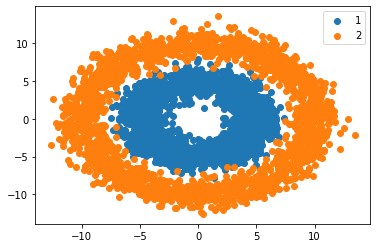

In [5]:
rho_1 = 5 + np.random.normal(scale = 1, size = M // 2)
phi_1 = np.random.uniform(0.0, 2 * np.pi, size = M // 2)
data_1 = np.stack((rho_1 * np.cos(phi_1), rho_1 * np.sin(phi_1)), axis = -1)
rho_2 = 10 + np.random.normal(scale = 1, size = M // 2)
phi_2 = np.random.uniform(0.0, 2 * np.pi, size = M // 2)
data_2 = np.stack((rho_2 * np.cos(phi_2), rho_2 * np.sin(phi_2)), axis = -1)
plt.scatter(data_1[:, 0], data_1[:, 1], label = "1")
plt.scatter(data_2[:, 0], data_2[:, 1], label = "2")
plt.legend()

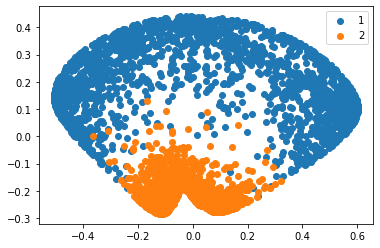

In [6]:
data_pca_1 = kpca.transform(data_1)
data_pca_2 = kpca.transform(data_2)
plt.scatter(data_pca_1[:, 1], data_pca_1[:, 2], label = "1")
plt.scatter(data_pca_2[:, 1], data_pca_2[:, 2], label = "2")
plt.legend()

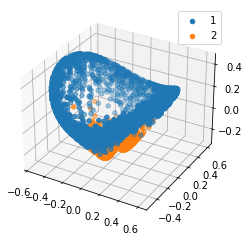

In [7]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(data_pca_1[:, 0], data_pca_1[:, 1], data_pca_1[:, 2], label = "1")
ax.scatter(data_pca_2[:, 0], data_pca_2[:, 1], data_pca_2[:, 2], label = "2")
plt.legend()

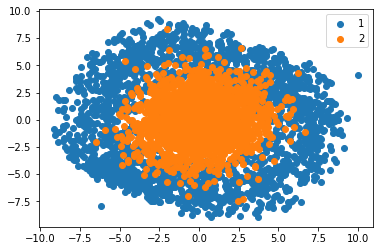

In [8]:
data_1_inv = kpca.inverse_transform(data_pca_1)
data_2_inv = kpca.inverse_transform(data_pca_2)
plt.scatter(data_1_inv[:, 0], data_1_inv[:, 1], label = "1")
plt.scatter(data_2_inv[:, 0], data_2_inv[:, 1], label = "2")
plt.legend()

Here, the transform is wrong due to the bug in `scikit-learn` inverse transform function. Make sure to use `scikit-learn>=0.24.2`

# Kernel PCA in `spax`

In [9]:
my_kpca = spax.KernelPCA(N = 3, kernel_kwargs = {"gamma": 0.1}, inverse_kernel = "same", α = 1.0)
my_kpca.fit(data.T)

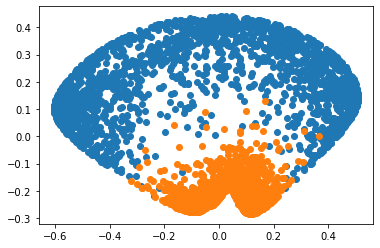

In [10]:
data_pca_1 = my_kpca.transform(data_1.T)
data_pca_2 = my_kpca.transform(data_2.T)
plt.scatter(data_pca_1[1], data_pca_1[2], label = "1")
plt.scatter(data_pca_2[1], data_pca_2[2], label = "2")

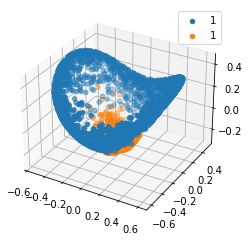

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(data_pca_1[0], data_pca_1[1], data_pca_1[2], label = "1")
ax.scatter(data_pca_2[0], data_pca_2[1], data_pca_2[2], label = "1")
plt.legend()

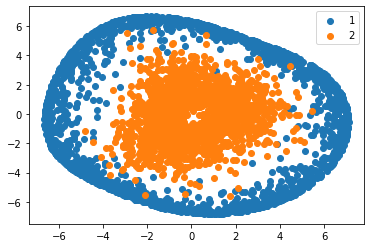

In [12]:
data_1_inv = my_kpca.inverse_transform(data_pca_1)
data_2_inv = my_kpca.inverse_transform(data_pca_2)
plt.scatter(*data_1_inv, label = "1")
plt.scatter(*data_2_inv, label = "2")
plt.legend()

# More Flexibility of an inverse transform
Sklear implements Kernel Ridge Regression transforming once more from N kPCA components with a kernel trick to another kernel space. For this, it uses a kernel specified initially.

Here we add two flexibilities:
- using no new kernel,
- changing a kernel in Kernel Ridge Regression.

## No new kernel
As one can see the results are very similar to having the same kernel, at least in this example.

In [13]:
my_kpca = spax.KernelPCA(N = 3, α = 1.0, kernel_kwargs = {"gamma": 0.1}, inverse_kernel = None)
my_kpca.fit(data.T)

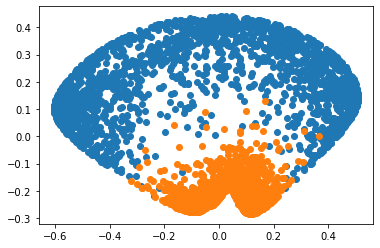

In [14]:
data_pca_1 = my_kpca.transform(data_1.T)
data_pca_2 = my_kpca.transform(data_2.T)
plt.scatter(data_pca_1[1], data_pca_1[2], label = "1")
plt.scatter(data_pca_2[1], data_pca_2[2], label = "2")

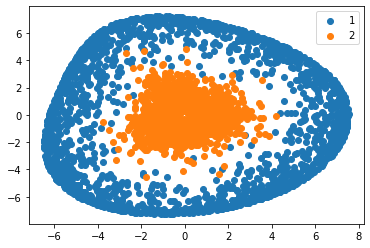

In [15]:
data_1_inv = my_kpca.inverse_transform(data_pca_1)
data_2_inv = my_kpca.inverse_transform(data_pca_2)
plt.scatter(*data_1_inv, label = "1")
plt.scatter(*data_2_inv, label = "2")
plt.legend()

## Different kernel

In [16]:
my_kpca = spax.KernelPCA(
    N = 3, 
    α = 1.0, 
    kernel = "rbf", kernel_kwargs = {"gamma": 0.1}, 
    inverse_kernel = "rbf", inverse_kernel_kwargs = {"gamma": 100.0},
    )
my_kpca.fit(data.T)

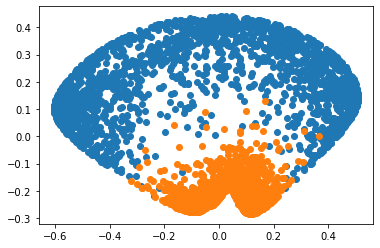

In [17]:
data_pca_1 = my_kpca.transform(data_1.T)
data_pca_2 = my_kpca.transform(data_2.T)
plt.scatter(data_pca_1[1], data_pca_1[2], label = "1")
plt.scatter(data_pca_2[1], data_pca_2[2], label = "2")

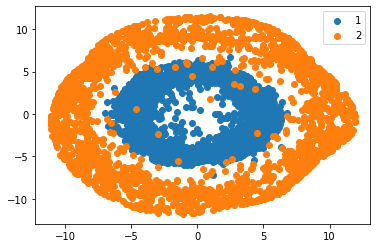

In [18]:
data_1_inv = my_kpca.inverse_transform(data_pca_1)
data_2_inv = my_kpca.inverse_transform(data_pca_2)
plt.scatter(*data_1_inv, label = "1")
plt.scatter(*data_2_inv, label = "2")
plt.legend()

# Multi-GPU kernel PCA test

In [19]:
jax.devices("cpu"), jax.devices("gpu")

([CpuDevice(id=0)],
 [GpuDevice(id=0), GpuDevice(id=1), GpuDevice(id=2), GpuDevice(id=3)])

## Same kernel

In [20]:
my_kpca = spax.KernelPCA_m(N = 3, devices = jax.devices("gpu"), kernel_kwargs = {"gamma": 0.1}, inverse_kernel = "same", α = 1.0)
my_kpca.fit(data.T)

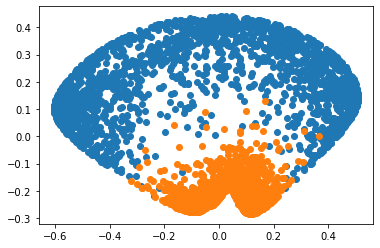

In [21]:
data_pca_1 = my_kpca.transform(data_1.T)
data_pca_2 = my_kpca.transform(data_2.T)
plt.scatter(data_pca_1[1], data_pca_1[2], label = "1")
plt.scatter(data_pca_2[1], data_pca_2[2], label = "2")

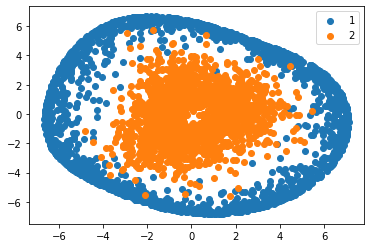

In [22]:
data_1_inv = my_kpca.inverse_transform(data_pca_1)
data_2_inv = my_kpca.inverse_transform(data_pca_2)
plt.scatter(*data_1_inv, label = "1")
plt.scatter(*data_2_inv, label = "2")
plt.legend()

## No new kernel

In [23]:
my_kpca = spax.KernelPCA_m(N = 3, devices = jax.devices("gpu"), α = 1.0, kernel_kwargs = {"gamma": 0.1}, inverse_kernel = None)
my_kpca.fit(data.T)

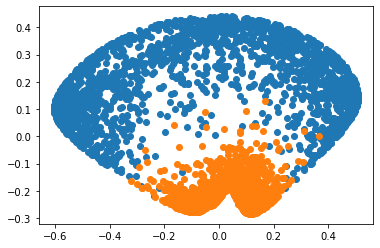

In [24]:
data_pca_1 = my_kpca.transform(data_1.T)
data_pca_2 = my_kpca.transform(data_2.T)
plt.scatter(data_pca_1[1], data_pca_1[2], label = "1")
plt.scatter(data_pca_2[1], data_pca_2[2], label = "2")

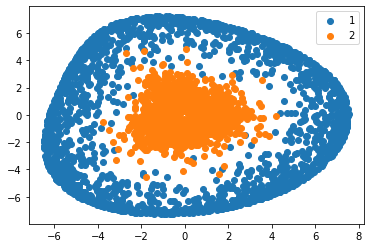

In [25]:
data_1_inv = my_kpca.inverse_transform(data_pca_1)
data_2_inv = my_kpca.inverse_transform(data_pca_2)
plt.scatter(*data_1_inv, label = "1")
plt.scatter(*data_2_inv, label = "2")
plt.legend()

## Different kernel

In [26]:
my_kpca = spax.KernelPCA_m(
    N = 3,
    devices = jax.devices("gpu"),
    α = 1.0, 
    kernel = "rbf", kernel_kwargs = {"gamma": 0.1}, 
    inverse_kernel = "rbf", inverse_kernel_kwargs = {"gamma": 100.0},
    )
my_kpca.fit(data.T)

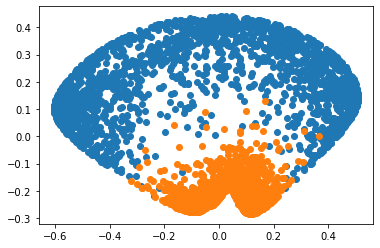

In [27]:
data_pca_1 = my_kpca.transform(data_1.T)
data_pca_2 = my_kpca.transform(data_2.T)
plt.scatter(data_pca_1[1], data_pca_1[2], label = "1")
plt.scatter(data_pca_2[1], data_pca_2[2], label = "2")

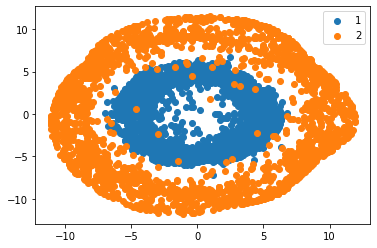

In [28]:
data_1_inv = my_kpca.inverse_transform(data_pca_1)
data_2_inv = my_kpca.inverse_transform(data_pca_2)
plt.scatter(*data_1_inv, label = "1")
plt.scatter(*data_2_inv, label = "2")
plt.legend()

## Large database test

In [29]:
my_kpca = spax.KernelPCA_m(
    N = 15,
    devices = jax.devices("gpu"),
    α = 1.0, 
    kernel = "rbf", kernel_kwargs = {"gamma": 0.1}, 
    inverse_kernel = "rbf", inverse_kernel_kwargs = {"gamma": 100.0},
    )
key = jax.random.PRNGKey(0)
d = jax.random.normal(key, shape = (int(3*1e6), 7000), dtype = jnp.float32)
d = np.array(d, dtype = np.float32)

In [ ]:
my_kpca.fit(d, batch_size_samples = 350, batch_size_dim = 18750)

In [ ]:
data_pca = my_kpca.transform(d, batch_size_samples = 350)

In [ ]:
data_inv = my_kpca.inverse_transform(data_pca, batch_size_samples = 350)